In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
# get list of top 20 recommended products by user
rec_list = pd.read_csv('top20_products_recom.csv')

# get each user's actual cart
path = '/Users/Jeff/Documents/Insight/Data'
order_products__prior = pd.read_csv(path+'/instacart_2017_05_01/order_products__prior.csv')
orders = pd.read_csv(path+'/instacart_2017_05_01/orders.csv') #need order data to join user_id to order_products__train

### Plan:
1. For each of the train users, check their past shopping history, and see how many of the top X recommended items are in it.
2. Divide that number by X, to get a fraction by user. Then plot distn and average.

In [3]:
%%time

# For each user, get number of products they've purchased in prior

# Get prior orders by user
users_order_prior = orders.loc[orders['eval_set'].map(lambda x: x in ['prior'])]

# Merge products in prior orders to the user for each order
print(len(order_products__prior))
display(order_products__prior.head(5))
user_order_products_prior_train = order_products__prior.merge(users_order_prior[['order_id','user_id']],
                                                        on='order_id')
print(len(user_order_products_prior_train))
display(user_order_products_prior_train.head(5))

# Check join worked
display(users_order_prior.loc[users_order_prior['order_id']==2]) # does this return user 202279?

32434489


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


32434489


,order_id,product_id,add_to_cart_order,reordered,user_id
0,2,33120,1,1,202279
1,2,28985,2,1,202279
2,2,9327,3,0,202279
3,2,45918,4,1,202279
4,2,30035,5,0,202279


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3355525,2,202279,prior,3,5,9,8.0


CPU times: user 5.37 s, sys: 3.97 s, total: 9.34 s
Wall time: 11.3 s


In [4]:
%%time

# Group products ordered by user
user_products_freq_train_long = user_order_products_prior_train[['user_id','product_id']]\
                                .groupby(['user_id','product_id']).size()
# display(user_products_freq_train_long.head(25))

# Reset index to remove MultiIndex
user_products_freq_train_long = user_products_freq_train_long.reset_index()
user_products_freq_train_long.columns = ['user_id','product_id','freq']
display(user_products_freq_train_long.head(25))

,user_id,product_id,freq
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3
5,1,13176,2
6,1,14084,1
7,1,17122,1
8,1,25133,8
9,1,26088,2


CPU times: user 13 s, sys: 7.6 s, total: 20.6 s
Wall time: 20 s


In [5]:
rec_list.drop(['Unnamed: 0'],axis=1,inplace=True)
rec_list.head()

,product_id,product_name,organic,freq_rank,user_id,rec_rank
0,13176,Bag of Organic Bananas,1,2,1,1
1,21137,Organic Strawberries,1,3,1,2
2,24852,Banana,0,1,1,3
3,21903,Organic Baby Spinach,1,4,1,4
4,39275,Organic Blueberries,1,11,1,5


In [6]:
#How many users will we validate on?
len(rec_list['user_id'].unique())

50000

In [8]:
len(users_order_prior['user_id'].unique()) #confirm same number of users as we have recommendations for.

206209

In [11]:
%%time

# First, group order_products__prior by user_id, and store each list of unique products as a dictionary with "user_id" as key.
prods_dict = dict(user_products_freq_train_long.groupby('user_id')['product_id'].apply(list))
print('Ordered products for User 1: ',prods_dict[1])
user_products_freq_train_long.loc[user_products_freq_train_long['user_id']==1] #check dictionary result is as expected

Ordered products for User 1:  [196, 10258, 10326, 12427, 13032, 13176, 14084, 17122, 25133, 26088, 26405, 30450, 35951, 38928, 39657, 41787, 46149, 49235]
CPU times: user 27.2 s, sys: 867 ms, total: 28.1 s
Wall time: 28.9 s


,user_id,product_id,freq
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3
5,1,13176,2
6,1,14084,1
7,1,17122,1
8,1,25133,8
9,1,26088,2


### Adding a column for each recommended item representing whether item was purchased by user before


In [13]:
%%time

# Then, map function over all recommended items (slow, but we only need once).
def rec_prod_ordered_before(rec_row):
    # For each of the recommended items, check if the id exists in the list of products stored in the dictionary.
    return rec_row['product_id'] in prods_dict[rec_row['user_id']]

# Test function on one row first:
display(rec_list.iloc[0])
display(prods_dict[1])
display(rec_prod_ordered_before(rec_list.iloc[0])) # User 1 bought Organic bananas before, so returned true as expected.

# Map function over all recommended items:
rec_list['actually_purchased_before'] = rec_list.apply(rec_prod_ordered_before,axis=1)
rec_list['never_purchased_before'] = ~(rec_list['actually_purchased_before'])
display(rec_list)
# Then can calculate serendipity_at_k using groupby and taking top k.

product_id                                    13176
product_name                 Bag of Organic Bananas
organic                                           1
freq_rank                                         2
user_id                                           1
rec_rank                                          1
actually_purchased_before                      True
Name: 0, dtype: object

[196,
 10258,
 10326,
 12427,
 13032,
 13176,
 14084,
 17122,
 25133,
 26088,
 26405,
 30450,
 35951,
 38928,
 39657,
 41787,
 46149,
 49235]

True

,product_id,product_name,organic,freq_rank,user_id,rec_rank,actually_purchased_before,never_purchased_before
0,13176,Bag of Organic Bananas,1,2,1,1,True,False
1,21137,Organic Strawberries,1,3,1,2,False,True
2,24852,Banana,0,1,1,3,False,True
3,21903,Organic Baby Spinach,1,4,1,4,False,True
4,39275,Organic Blueberries,1,11,1,5,False,True
...,...,...,...,...,...,...,...,...
999995,5876,Organic Lemon,1,25,78707,16,False,True
999996,16797,Strawberries,0,8,78707,17,False,True
999997,4605,Yellow Onions,0,21,78707,18,True,False
999998,8518,Organic Red Onion,1,20,78707,19,True,False


CPU times: user 23.4 s, sys: 235 ms, total: 23.6 s
Wall time: 24.2 s


In [14]:
#78% of top 20 recommendations were new
rec_list['never_purchased_before'].value_counts(normalize=True) 

True     0.78607
False    0.21393
Name: never_purchased_before, dtype: float64

In [15]:
# export so don't have to do it again.
rec_list.to_csv('top20_products_recom_purchasedbefore.csv')

### Calculating serendipity at k

In [3]:
# if re-running this notebook, load the DF from CSV
rec_list = pd.read_csv('top20_products_recom_purchasedbefore.csv')
rec_list.drop(['Unnamed: 0'],axis=1,inplace=True)

In [18]:
# Calculating precision at k for multiple ks
def serendipity_at_k(k):
    all_hits = rec_list.loc[rec_list['rec_rank']<=k][['user_id','never_purchased_before']].groupby('user_id').sum()
    all_satks = all_hits.values/k
    return all_satks, all_satks.mean()

satk_by_k = []
for sample_k in np.arange(1,21):
    satk_all, mean_satk = serendipity_at_k(sample_k)
    satk_by_k.append(mean_satk)
    
print(satk_by_k)

[0.61132, 0.64244, 0.6620533333333333, 0.67398, 0.68528, 0.69683, 0.7075514285714287, 0.7169825, 0.7254666666666667, 0.733508, 0.7410036363636363, 0.747765, 0.7540753846153848, 0.7598442857142857, 0.7650933333333334, 0.7699075, 0.7744011764705883, 0.7785333333333334, 0.7823652631578947, 0.7860699999999998]


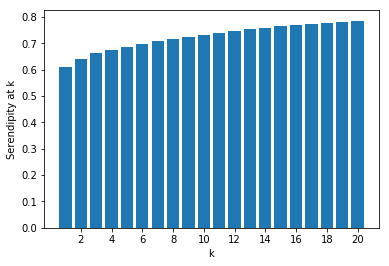

In [19]:
plt.figure()
plt.bar(np.arange(1,21),satk_by_k)
plt.xticks(np.arange(2,21,2))
plt.xlabel('k')
plt.ylabel('Serendipity at k')
plt.show()

10


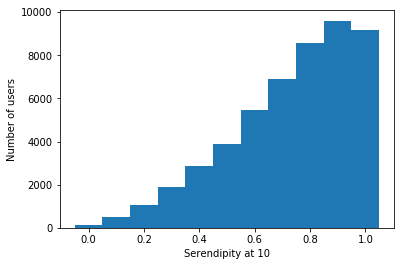

0.733508


0.22421064634847296

In [26]:
sample_k = 10
print(sample_k)
satk_all, mean_satk = serendipity_at_k(sample_k)
plt.hist(satk_all,bins=np.arange(-0.05,1.15,0.1))
plt.xlabel('Serendipity at 10')
plt.ylabel('Number of users')
plt.show()
print(mean_satk)
np.std(satk_all)